In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 課題1


In [5]:
import pandas as pd
import numpy as np 

In [3]:
#データ読み込み
df = pd.read_csv('/content/drive/My Drive/授業/データサイエンス演習2/class-master/all3.csv', sep=',')
df2 = pd.read_csv('/content/drive/My Drive/授業/データサイエンス演習2/class-master/yubin_jusho.tsv', sep='\t', header=None)

In [4]:
df

,date,observer,station,latitude,longitude,row(0-3119),column(0-2599),altitude,temperature,penalty
0,2018-01-01 00:00:00,1,11001,45.5200,141.9350,57,1594,26,-0.70,0
1,2018-01-01 00:00:00,1,11016,45.4150,141.6783,70,1574,3,-1.99,0
2,2018-01-01 00:00:00,1,11046,45.3050,141.0450,83,1523,65,0.38,0
3,2018-01-01 00:00:00,1,11061,45.4033,141.8017,71,1584,8,-4.89,0
4,2018-01-01 00:00:00,1,11076,45.3350,142.1700,79,1613,13,-0.58,0
...,...,...,...,...,...,...,...,...,...,...
6503,2018-01-07 00:00:00,1,94081,24.3367,124.1633,2599,173,6,17.77,0
6504,2018-01-07 00:00:00,1,94086,24.3950,124.2450,2592,179,31,17.75,0
6505,2018-01-07 00:00:00,1,94101,24.2650,123.8717,2608,149,33,17.27,0
6506,2018-01-07 00:00:00,1,94116,24.0550,123.7667,2633,141,38,17.64,0


In [5]:
df2['地名']=df2[0]+df2[1] #地名を一列に統合
df2.drop([0,1], axis=1, inplace=True)
df2.rename(columns={2: '緯度', 3: '経度'}, inplace=True) #列名変更
df2

,緯度,経度,地名
0,43.851389,142.698839,北海道上川郡愛別町愛山
1,43.892403,142.586497,北海道上川郡愛別町愛別
2,43.958292,142.710892,北海道上川郡愛別町旭山
3,43.897847,142.547264,北海道上川郡愛別町金富
4,43.908381,142.578386,北海道上川郡愛別町北町
...,...,...,...
312374,26.400675,127.732950,沖縄県中頭郡読谷村波平
312375,26.371231,127.755533,沖縄県中頭郡読谷村比謝
312376,26.367994,127.757014,沖縄県中頭郡読谷村比謝矼
312377,26.363578,127.752056,沖縄県中頭郡読谷村古堅


In [6]:
print(df[['station','latitude','longitude']]) #ステーション番号#緯度#経度

      station  latitude  longitude
0       11001   45.5200   141.9350
1       11016   45.4150   141.6783
2       11046   45.3050   141.0450
3       11061   45.4033   141.8017
4       11076   45.3350   142.1700
...       ...       ...        ...
6503    94081   24.3367   124.1633
6504    94086   24.3950   124.2450
6505    94101   24.2650   123.8717
6506    94116   24.0550   123.7667
6507    94121   24.0583   123.8033

[6508 rows x 3 columns]


In [7]:
#経度、緯度から地図上距離を算出するためのライブラリ
!pip install pyproj

     |████████████████████████████████| 10.9MB 271kB/s 


In [8]:
from pyproj import Geod
# ellpsは赤道半径、GPSはWGS84。距離は6,378,137m
g = Geod(ellps='WGS84')

In [9]:
#アメダスのステーション番号を入力として、最も近い地名と距離を返す
def search_observation_site(station_num: int) -> (str, float): 
  #ステーション番号から緯度と経度を取得
  lat, lon=df[df['station']==station_num].head(1)[['latitude', 'longitude']].values[0]
  #地図上距離の計算
  #単位は[m]
  distance_2d = g.inv(df2['経度'].values, df2['緯度'].values, [lon]*len(df2), [lat]*len(df2))[2]
  ##距離の計算2（単純に差分をとっただけのもの）
  ##pd.concat([(df2['緯度']-lat).abs(), (df2['経度']-lon).abs()], axis=1).sort_values(by=['緯度', '経度']).index[0]

  #昇順にソート
  sr=pd.Series(distance_2d).sort_values()

  #最も距離が近い地名を取得
  return df2.loc[sr.index[0]]['地名'], sr.values[0]

In [10]:
place, distance=search_observation_site(station_num=11076)
print('地名:', place)
print('距離[m]:', distance)

地名: 北海道宗谷郡猿払村浜鬼志別
距離[m]: 761.2894511518791


In [16]:
#全ステーションに対して、最も近い地名と距離を割当
place_distance=pd.DataFrame(list(map(search_observation_site, np.unique(df['station']))), columns=['地名', 'distance'], index=np.unique(df['station']))
#ステーション番号をカラムに
place_distance.reset_index(inplace=True)
place_distance.rename(columns={'index': 'station'}, inplace=True)
print(place_distance)
#アメダスの観測データフレームに地名と距離を追加
add_place_distance_df = pd.merge(df, place_distance, on='station')

     station              地名     distance
0      11001       北海道稚内市宗谷岬  1452.160626
1      11016        北海道稚内市中央   139.423858
2      11046    北海道礼文郡礼文町香深村   522.523572
3      11061  北海道稚内市声問村（メクマ）   843.844364
4      11076   北海道宗谷郡猿払村浜鬼志別   761.289451
..       ...             ...          ...
925    94081       沖縄県石垣市登野城   389.049949
926    94086        沖縄県石垣市盛山  1231.172988
927    94101   沖縄県八重山郡竹富町南風見  1111.212706
928    94116   沖縄県八重山郡竹富町波照間  1109.766153
929    94121   沖縄県八重山郡竹富町波照間  2644.004130

[930 rows x 3 columns]


In [19]:
add_place_distance_df[add_place_distance_df['station']==11016]

,date,observer,station,latitude,longitude,row(0-3119),column(0-2599),altitude,temperature,penalty,地名,distance
7,2018-01-01 00:00:00,1,11016,45.415,141.6783,70,1574,3,-1.99,0,北海道稚内市中央,139.423858
8,2018-01-02 00:00:00,1,11016,45.415,141.6783,70,1574,3,0.51,0,北海道稚内市中央,139.423858
9,2018-01-03 00:00:00,1,11016,45.415,141.6783,70,1574,3,-0.09,0,北海道稚内市中央,139.423858
10,2018-01-04 00:00:00,1,11016,45.415,141.6783,70,1574,3,-1.79,0,北海道稚内市中央,139.423858
11,2018-01-05 00:00:00,1,11016,45.415,141.6783,70,1574,3,-2.19,0,北海道稚内市中央,139.423858
12,2018-01-06 00:00:00,1,11016,45.415,141.6783,70,1574,3,-2.59,0,北海道稚内市中央,139.423858
13,2018-01-07 00:00:00,1,11016,45.415,141.6783,70,1574,3,-4.49,0,北海道稚内市中央,139.423858


# 課題2

In [29]:
#colabで正常にcartopyを扱うため
!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get -qq update

!apt-get -qq build-dep python3-cartopy
!pip uninstall -y shapely

!pip install --no-binary cartopy cartopy==0.17.0

deb-src http://archive.ubuntu.com/ubuntu/ bionic main restricted
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates main restricted
deb-src http://archive.ubuntu.com/ubuntu/ bionic universe
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates universe
deb-src http://archive.ubuntu.com/ubuntu/ bionic multiverse
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates multiverse
deb-src http://archive.ubuntu.com/ubuntu/ bionic-backports main restricted universe multiverse
deb-src http://security.ubuntu.com/ubuntu/ bionic-security main restricted
deb-src http://security.ubuntu.com/ubuntu/ bionic-security universe
deb-src http://security.ubuntu.com/ubuntu/ bionic-security multiverse
deb-src https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/
Extracting templates from packages: 100%
Selecting previously unselected package libmagic-mgc.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../00-libmagic-mgc_1%3a5.32-2ubuntu0.4_amd64.

In [30]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import datetime as dt
from datetime import timedelta  

In [70]:
#緯度と経度の範囲
lon_samples=np.arange(122.0000, 154.4875,0.0125)
lat_samples=np.arange(46.0000, 20.0083, -0.0167)

In [71]:
#2018-01-01 00:00:00だけ抽出
date = '2018-01-01 00:00:00'
d_sub = df[df['date'] == date]

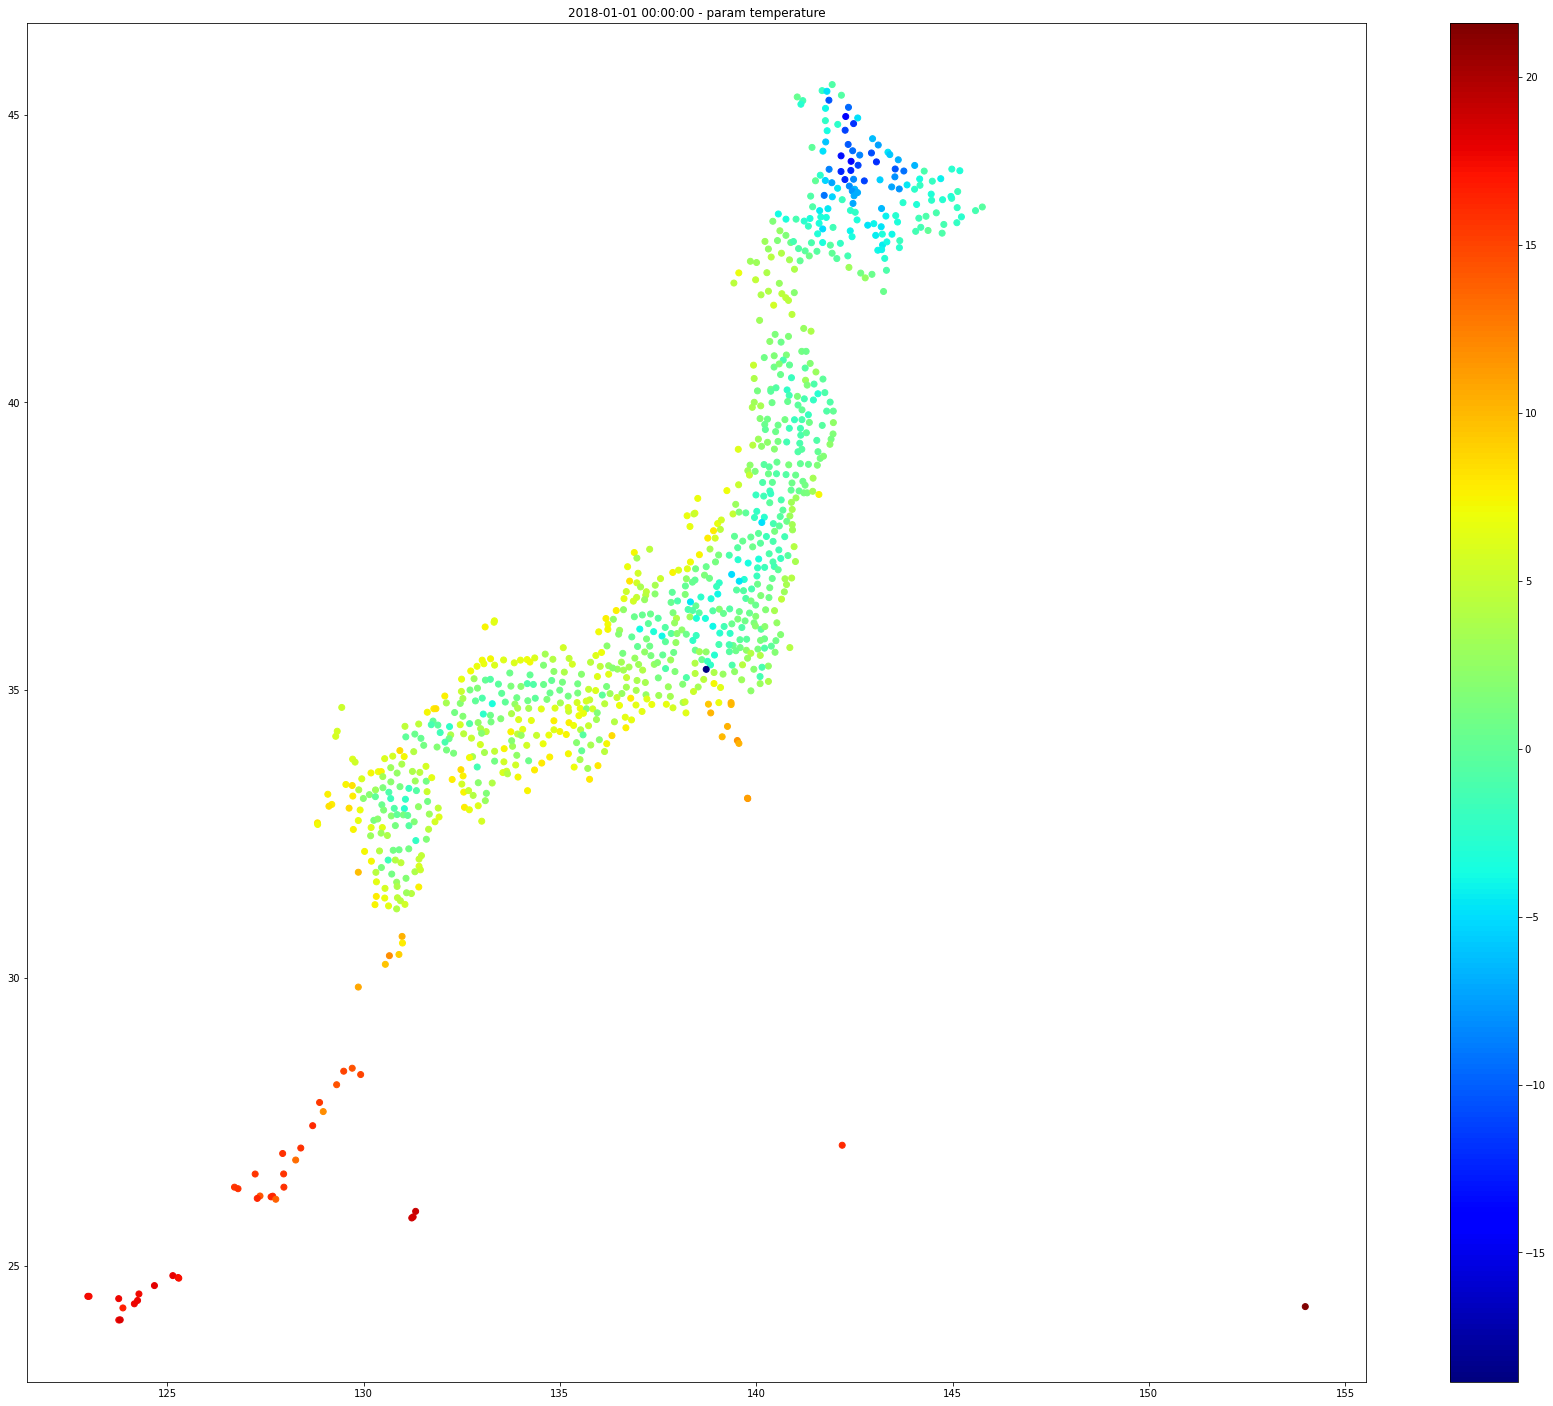

In [16]:
#アメダス地点と気温だけ
plt.figure(figsize=(30,25))
plt.scatter(d_sub['longitude'], d_sub['latitude'], c=d_sub['temperature'], cmap='jet')
plt.colorbar()
plt.title(date+' - param temperature')
plt.show()

In [66]:
# 50m解像度用の陸地データ作成
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
states_10m  = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '10m', 
                                           edgecolor='gray',
                                           facecolor='none')
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m', 
                                         edgecolor='face',                   # same color with facecolor
                                         facecolor=cfeature.COLORS['water'])

In [496]:
#メッシュ+ステーション地点+温度(2018-01-01 00:00:00の時)
def plot_japan_with_tamp(lon_min, lon_max, lat_min, lat_max):
  plt.figure(figsize=(40,35))
  ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=(lon_min+lon_max)/2,
                                                central_latitude=(lat_min+lat_max)/2,
                                                standard_parallels=(30,60)))
  ax.set_extent([lon_min,lon_max,lat_min,lat_max],ccrs.PlateCarree())
  ax.add_feature(land_50m)
  ax.add_feature(states_10m)
  ax.add_feature(ocean_50m)
  ax.coastlines(resolution='50m', lw=0.5)
  gl = ax.gridlines(crs=ccrs.PlateCarree()
          , draw_labels=False
          , linewidth=1, alpha=0.8)
  gl.xlocator = mticker.FixedLocator(lon_samples)    
  gl.ylocator = mticker.FixedLocator(lat_samples)
  plt.scatter(d_sub['longitude'], d_sub['latitude'], c=d_sub['temperature'], cmap='jet', transform=ccrs.PlateCarree(), zorder=3)
  plt.colorbar()
  plt.title(date+' - param temperature')
  plt.show()

/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


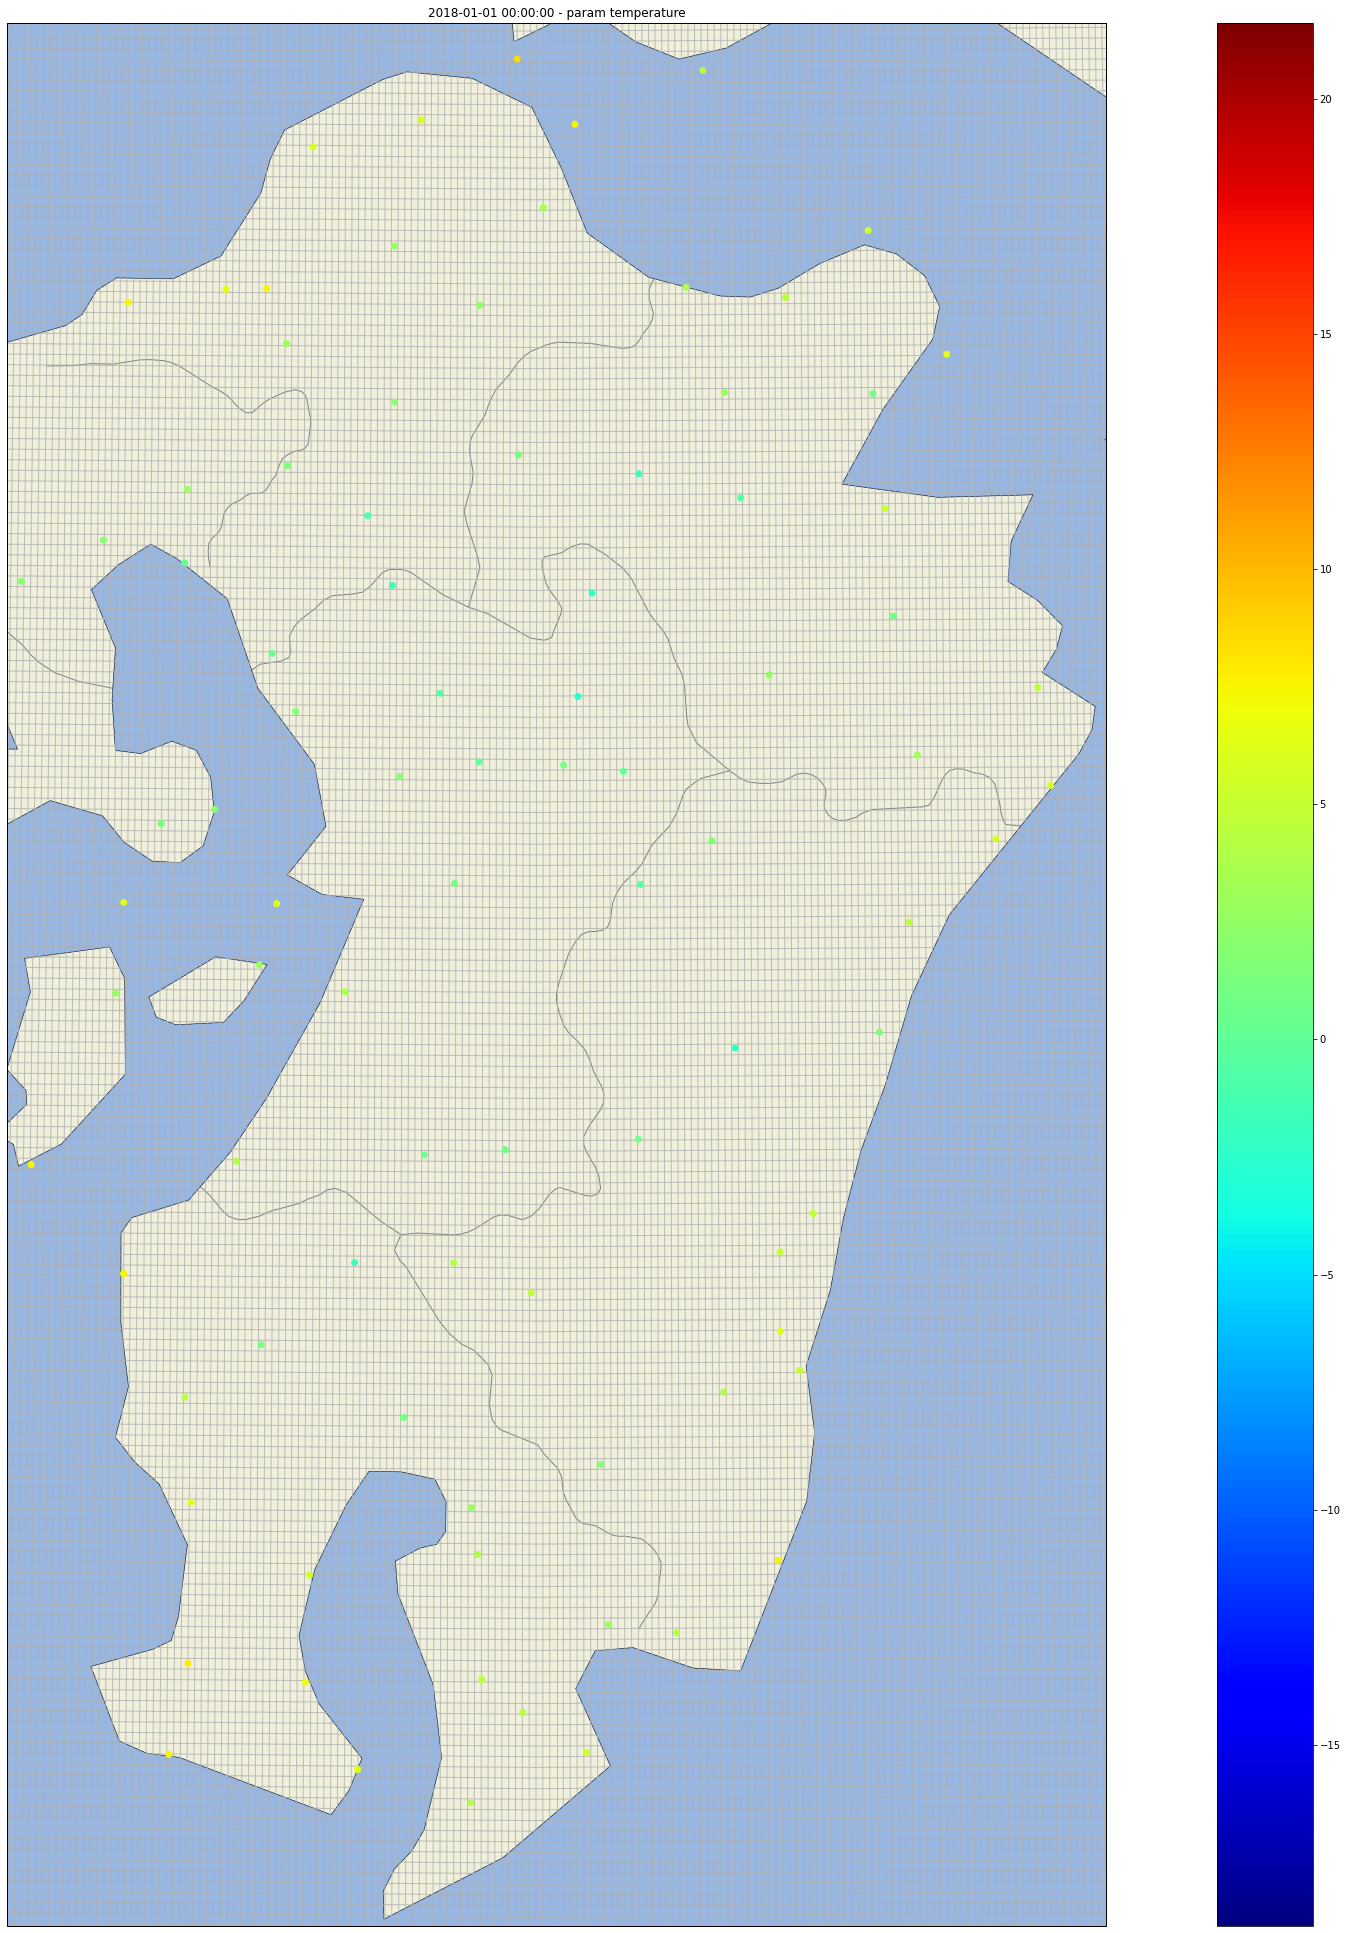

In [497]:
#日本: 130-150, 30-46
#九州
plot_japan_with_tamp(130,132,31,34)

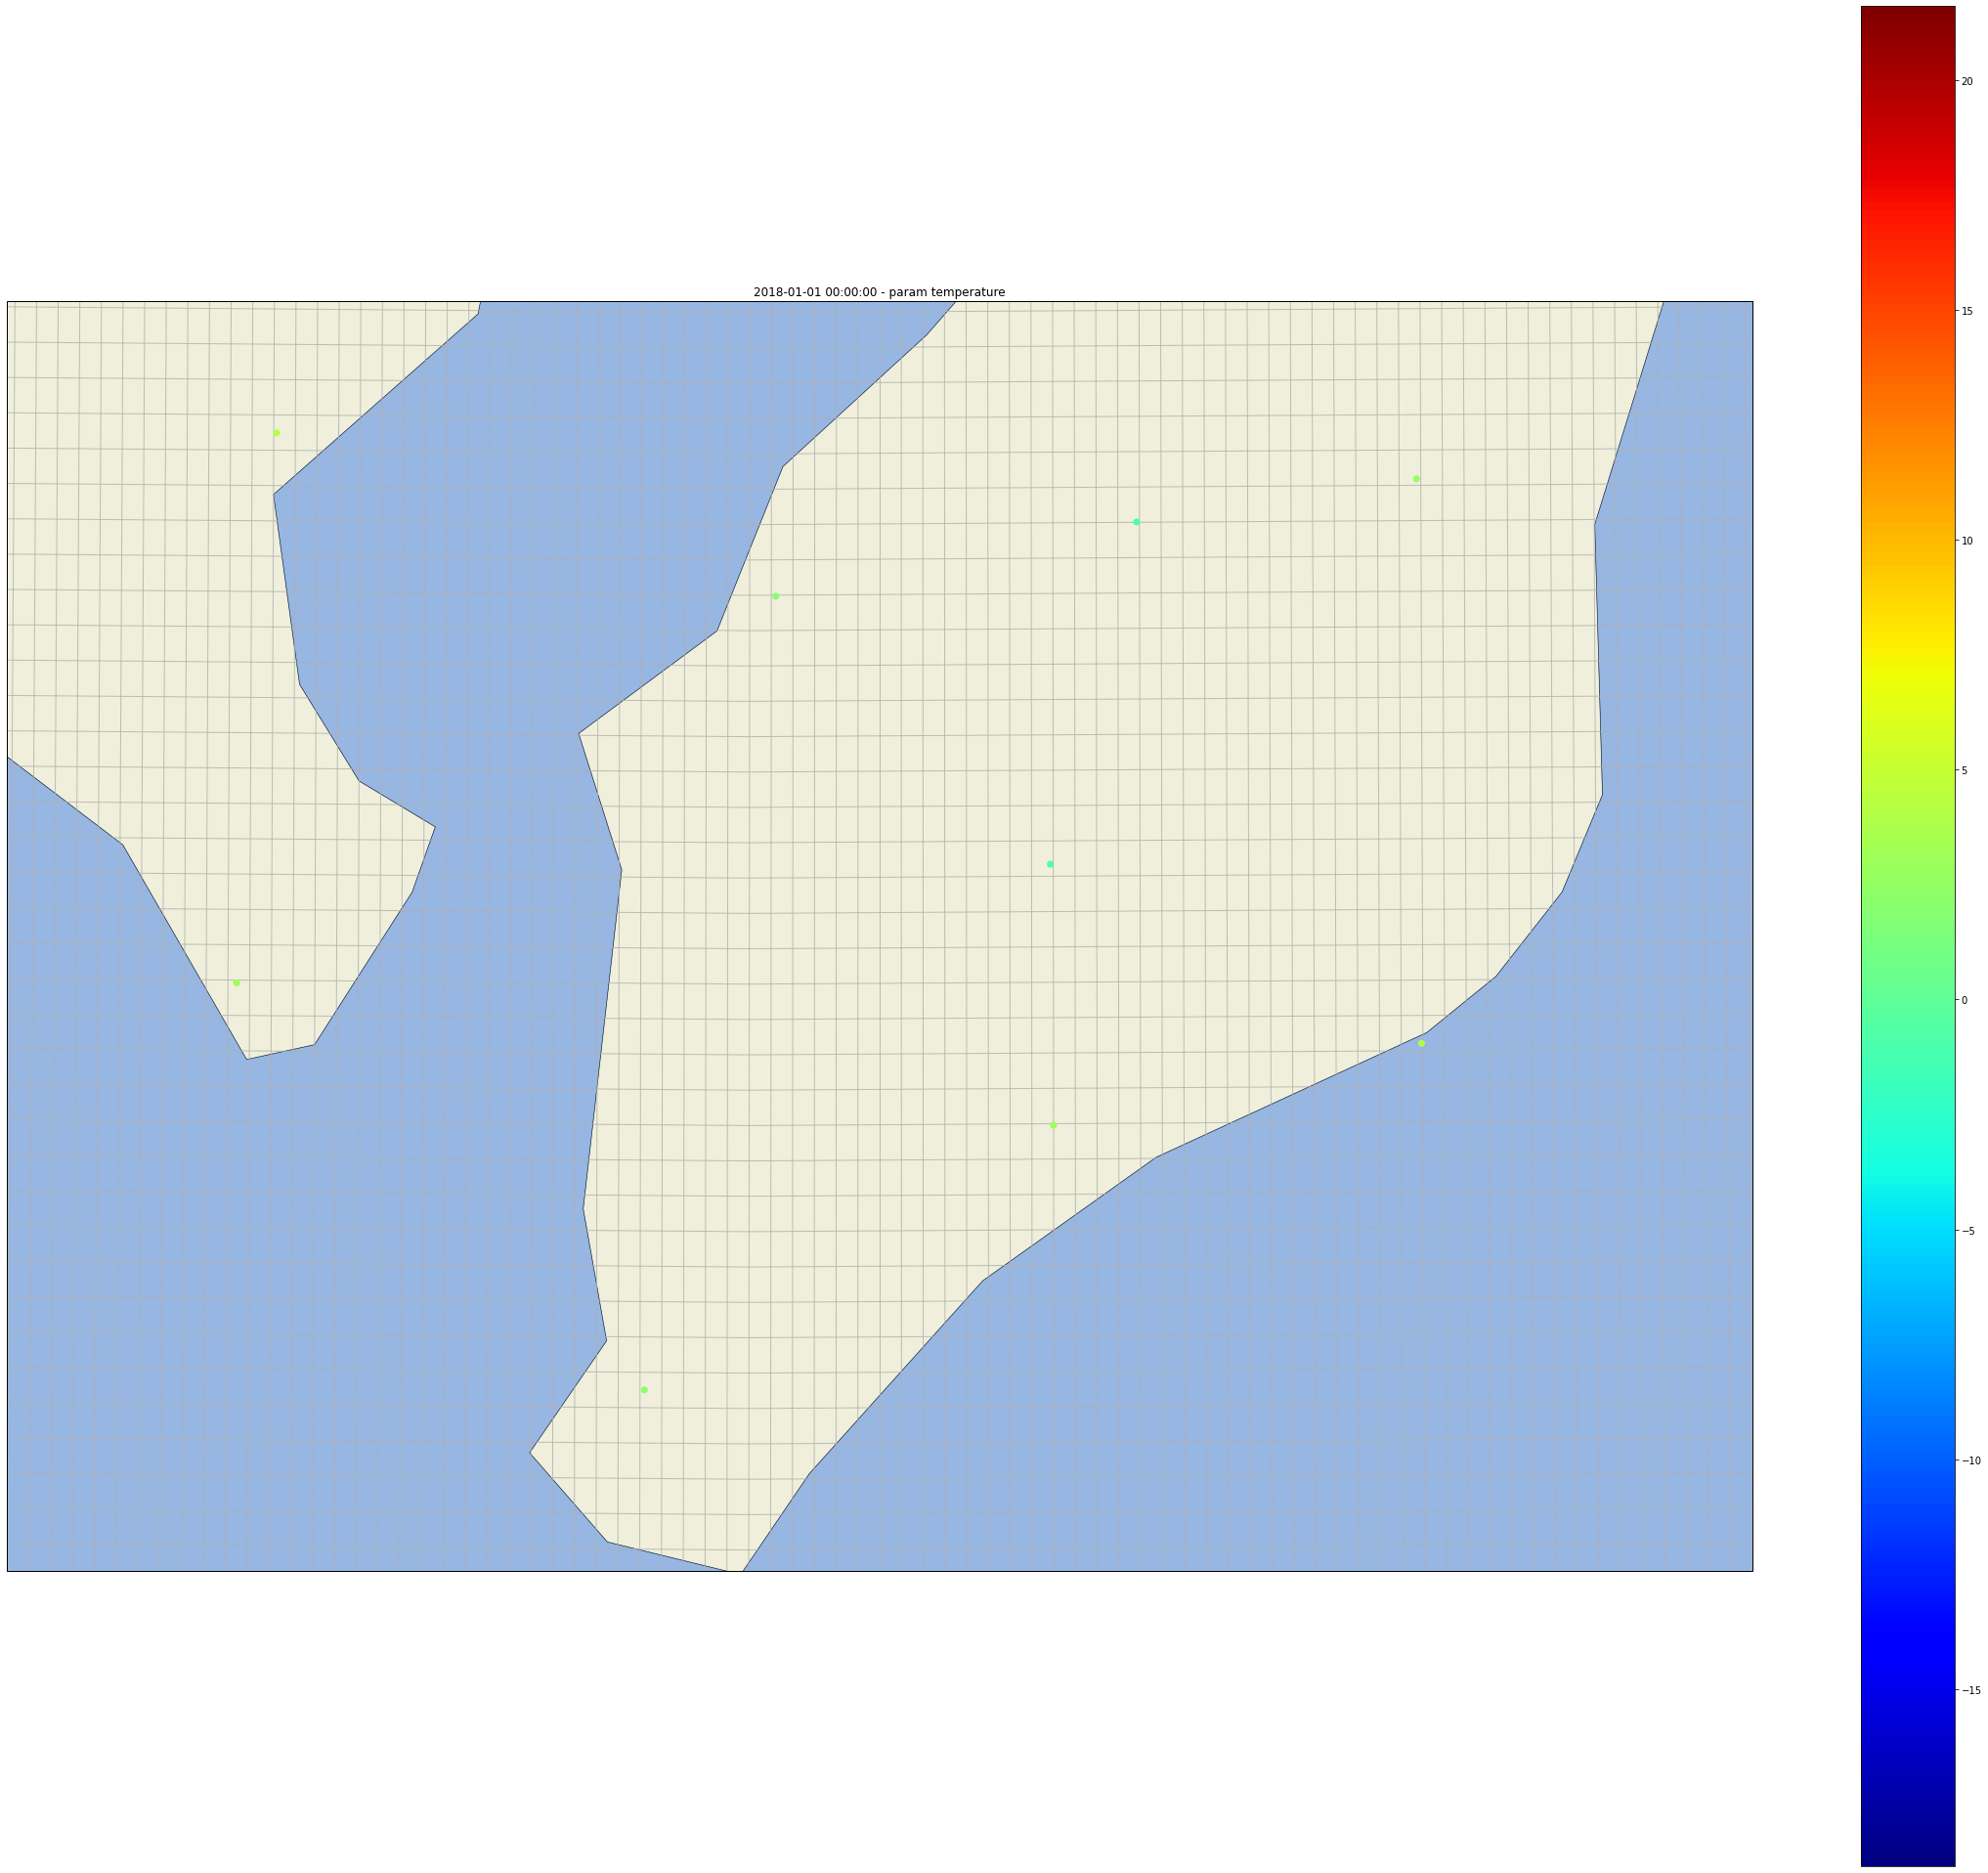

In [498]:
#千葉近郊
plot_japan_with_tamp(139.5,140.5,34.9,35.5)

# 課題3


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [6]:
train_data = pd.read_csv('/content/drive/My Drive/授業/データサイエンス演習2/class-master/takasaki_temp.csv', sep=',', header=None)
test_data = pd.read_csv('/content/drive/My Drive/授業/データサイエンス演習2/class-master/takasaki_temp_test.csv', sep=',', header=None)
test_label = pd.read_csv('/content/drive/My Drive/授業/データサイエンス演習2/class-master/takasaki_temp_test.label', sep=',', header=None)

In [7]:
#1時間で気温はそこまで変化しないと思われるので
#時間単位でまとめる
train_data.index=pd.DatetimeIndex(train_data[0])
train_data.drop(columns=[0], axis=1, inplace=True)

test_data.index=pd.DatetimeIndex(test_data[0])
test_data.drop(columns=[0], axis=1, inplace=True)

test_label.index=pd.DatetimeIndex(test_label[0])
test_label.drop(columns=[0], axis=1, inplace=True)

In [8]:
train_data=train_data.resample('h').mean()
test_data=test_data.resample('h').mean()
test_label=test_label.resample('h').mean()

In [145]:
train_data.head(5)

,1
0,
2018-01-01 00:00:00,-0.640000
2018-01-01 01:00:00,-0.173333
2018-01-01 02:00:00,0.226667
2018-01-01 03:00:00,0.910000
2018-01-01 04:00:00,0.676667


In [146]:
test_data.head(5)

,1
0,
2018-04-01 00:00:00,7.610000
2018-04-01 01:00:00,7.393333
2018-04-01 02:00:00,7.326667
2018-04-01 03:00:00,7.526667
2018-04-01 04:00:00,7.043333


In [147]:
test_label.head(5)

,1
0,
2018-04-15 00:00:00,10.276667
2018-04-15 01:00:00,10.276667
2018-04-15 02:00:00,10.260000
2018-04-15 03:00:00,10.293333
2018-04-15 04:00:00,10.460000


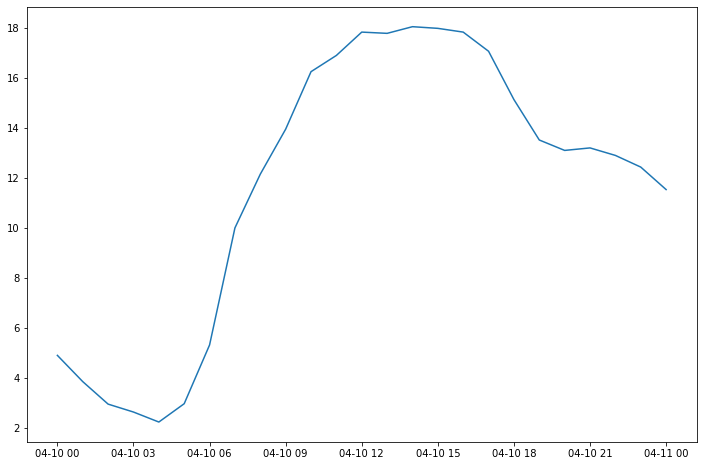

In [12]:
#2018-04-10の気温変化
from datetime import datetime
data_2018_4=test_data[(test_data.index<=datetime(2018,4,11)) & (test_data.index>=datetime(2018,4,10))]
plt.figure(figsize=(12,8))
plt.plot(data_2018_4.index, data_2018_4[1])

はじめに、時間帯(0~23)と1時間前の気温を特徴量にする

In [148]:
#正規化（標準化）
from sklearn import preprocessing
train_scaler = preprocessing.scale(train_data).ravel()
test_scaler = preprocessing.scale(test_data).ravel()
label_scaler = preprocessing.scale(test_label).ravel()

In [149]:
#時間をカテゴリ変数に（ex. 0:00→0）
#予測する気温がいつの時間なのか
hours=[]
test_hours=[]
for i in range(len(train_data)):
  hours.append(train_data.index[i].hour)
for i in range(len(test_data)):
  test_hours.append(test_data.index[i].hour)

In [150]:
#訓練、テストデータ作成
x_train=[]
for i in range(1,len(hours)):
  x_train.append([hours[i], train_scaler[i-1]])
x_train=pd.DataFrame(x_train)
x_train=pd.get_dummies(x_train, drop_first=True, columns=[0])

x_test=[]
for i in range(1,len(test_hours)):
  x_test.append([test_hours[i], test_scaler[i-1]])
x_test=pd.DataFrame(x_test)
x_test=pd.get_dummies(x_test, drop_first=True, columns=[0])

In [153]:
#訓練データの中身#2列目以降はダミー変数
pd.DataFrame(x_train)

,1,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10,0_11,0_12,0_13,0_14,0_15,0_16,0_17,0_18,0_19,0_20,0_21,0_22,0_23
0,-0.866315,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.788435,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.721680,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.607640,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.646580,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,1.325472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2155,1.075141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2156,0.902691,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2157,0.727459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [251]:
#ランダムフォレスト、学習、predict
model=RandomForestRegressor()
model.fit(x_train, train_scaler[1:])
pred=model.predict(x_test)

In [252]:
print('test score(R2): ', r2_score(pred, test_scaler[1:]))
print('test score(MSE): ', mean_squared_error(pred, test_scaler[1:]))

test score(R2):  0.9643087640873986
test score(MSE):  0.03466348062073997


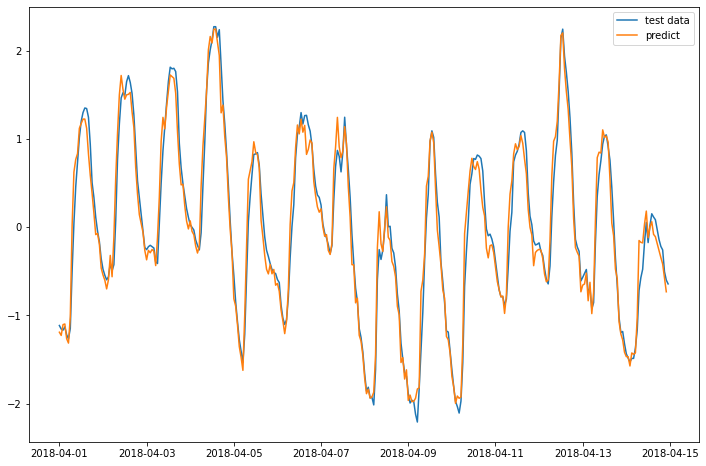

In [253]:
plt.figure(figsize=(12,8))
plt.plot(test_data.index, test_scaler, label='test data')
plt.plot(test_data.index[:-1], pred, label='predict')
plt.legend()

In [290]:
#学習したモデルを使って15日〜18日の気温を予測する
#4月14日の23時を元に予測を始める
basis=x_test.tail(1).values[0]
pred_list=[]
for i in range(len(test_label)):
  pre=model.predict(basis.reshape(1,-1))
  pred_list.append(pre[0])
  dummys=list(basis[1:])
  dummys.insert(0, dummys.pop(-1))
  #次の時間帯と今予測したものを、次のデータとする
  dummys.insert(0, pre[0])
  basis=np.array(dummys)
  print(basis)

[-0.73216579  1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[-0.75416711  0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[-0.87139992  0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[-0.8604396  0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         

In [296]:
print('label score(R2): ', r2_score(pred_list, label_scaler))
print('label score(MSE): ', mean_squared_error(pred_list, label_scaler))

label score(R2):  -0.934444567993052
label score(MSE):  0.7074988470530102


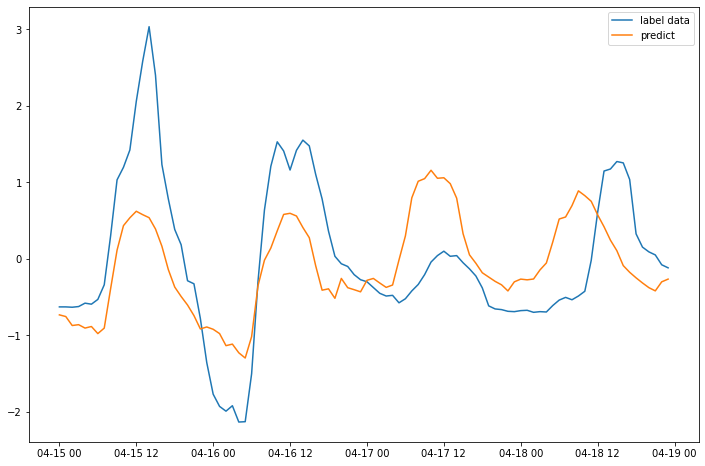

In [292]:
plt.figure(figsize=(12,8))
plt.plot(test_label.index, label_scaler, label='label data')
plt.plot(test_label.index, pred_list, label='predict')
plt.legend()

スライド窓で過去の気温の推移から推定

In [166]:
#スライド窓を作成
def moving_window_matrix(x,window_size):
    n = x.shape[0]
    stride = x.strides[0]
    return np.lib.stride_tricks.as_strided(x, shape=(n-window_size+1, window_size), strides=(stride,stride) ).copy()

In [167]:
#半日(12h)をスライド窓にする
#スライド窓12, ストライド1
size=12
train_window_data=moving_window_matrix(train_scaler,size)
test_window_data=moving_window_matrix(test_scaler,size)

In [168]:
train_window_data.shape

(2149, 12)

In [169]:
#訓練、テストデータ作成
y_train=[]
y_test=[]
for i in range(1, len(train_window_data)):
  y_train.append(train_window_data[i][-1])
for i in range(1, len(test_window_data)):
  y_test.append(test_window_data[i][-1])

x_train=train_window_data[:-1]
x_test=test_window_data[:-1]

In [170]:
#訓練データの中身
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.866315,-0.788435,-0.721680,-0.607640,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697
1,-0.788435,-0.721680,-0.607640,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,1.125207
2,-0.721680,-0.607640,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,1.125207,1.025075
3,-0.607640,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,1.125207,1.025075,0.905472
4,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,1.125207,1.025075,0.905472,0.618982
...,...,...,...,...,...,...,...,...,...,...,...,...
2143,0.524413,0.746929,1.205869,1.456200,1.756598,1.890108,1.981896,2.043088,2.029180,1.959644,1.806664,1.325472
2144,0.746929,1.205869,1.456200,1.756598,1.890108,1.981896,2.043088,2.029180,1.959644,1.806664,1.325472,1.075141
2145,1.205869,1.456200,1.756598,1.890108,1.981896,2.043088,2.029180,1.959644,1.806664,1.325472,1.075141,0.902691
2146,1.456200,1.756598,1.890108,1.981896,2.043088,2.029180,1.959644,1.806664,1.325472,1.075141,0.902691,0.727459


In [158]:
#ランダムフォレスト、学習、predict
model=RandomForestRegressor()
model.fit(x_train, y_train)
pred=model.predict(x_test)

In [159]:
print('test score(R2): ', r2_score(pred, y_test))
print('test score(MSE): ', mean_squared_error(pred, y_test))

test score(R2):  0.9676238774358176
test score(MSE):  0.031409047070776186


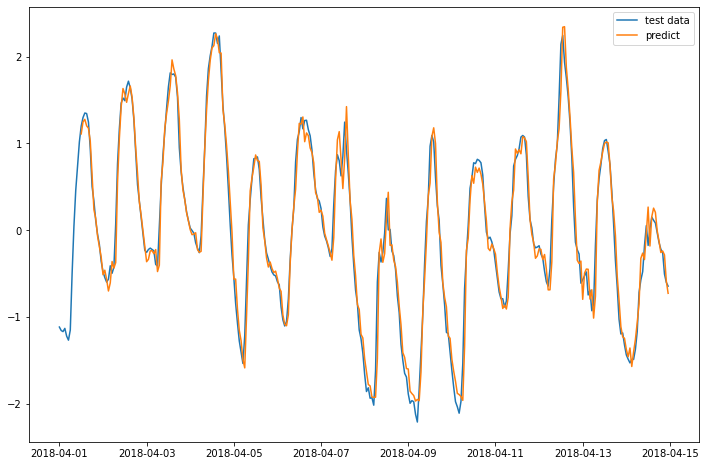

In [160]:
plt.figure(figsize=(12,8))
plt.plot(test_data.index, test_scaler, label='test data')
plt.plot(test_data.index[size:], pred, label='predict')
plt.legend()

In [98]:
#学習したモデルを使って15日〜18日の気温を予測する
#13日23時のデータを基に
basis=list(x_test[-1])
pred_list=[]
for i in range(len(test_label)):
  pre=model.predict(np.array(basis).reshape(1,-1))
  pred_list.append(pre[0])
  basis.pop(0)
  basis.append(pre[0])
  #print(basis)

In [99]:
print('label score(R2): ', r2_score(pred_list, label_scaler))
print('label score(MSE): ', mean_squared_error(pred_list, label_scaler))

label score(R2):  -1.8516588610656894
label score(MSE):  0.8043348078838369


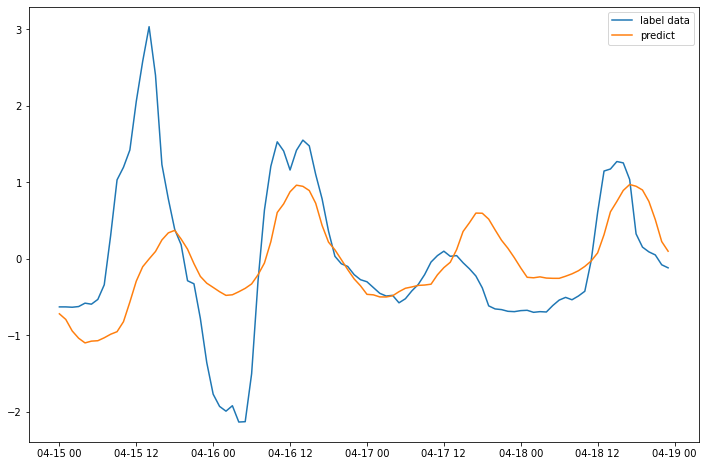

In [100]:
plt.figure(figsize=(12,8))
plt.plot(test_label.index, label_scaler, label='label data')
plt.plot(test_label.index, pred_list, label='predict')
plt.legend()

予測する気温の時間帯+過去のデータ（12時間前までの気温の推移）

In [162]:
#時間をカテゴリ変数に（ex. 0:00→0）
#予測する気温がいつの時間なのか
hours=[]
test_hours=[]
for i in range(len(train_window_data)):
  hours.append((size+i)%24)
for i in range(len(test_window_data)):
  test_hours.append((size+i)%24)

In [163]:
#訓練、テストデータ作成
y_train=[]
y_test=[]
for i in range(1, len(train_window_data)):
  y_train.append(train_window_data[i][-1])
for i in range(1, len(test_window_data)):
  y_test.append(test_window_data[i][-1])

x_train=np.concatenate([np.array(hours[:-1]).reshape(-1,1), train_window_data[:-1]], axis=1)
x_test=np.concatenate([np.array(test_hours[:-1]).reshape(-1,1), test_window_data[:-1]], axis=1)

In [164]:
x_train=pd.DataFrame(x_train)
x_train=pd.get_dummies(x_train, drop_first=True, columns=[0])
x_test=pd.DataFrame(x_test)
x_test=pd.get_dummies(x_test, drop_first=True, columns=[0])

In [165]:
#訓練データの中身
pd.DataFrame(x_train)

,1,2,3,4,5,6,7,8,9,10,11,12,0_1.0,0_2.0,0_3.0,0_4.0,0_5.0,0_6.0,0_7.0,0_8.0,0_9.0,0_10.0,0_11.0,0_12.0,0_13.0,0_14.0,0_15.0,0_16.0,0_17.0,0_18.0,0_19.0,0_20.0,0_21.0,0_22.0,0_23.0
0,-0.866315,-0.788435,-0.721680,-0.607640,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,-0.788435,-0.721680,-0.607640,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,1.125207,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.721680,-0.607640,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,1.125207,1.025075,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,-0.607640,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,1.125207,1.025075,0.905472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,-0.646580,-0.724461,-0.857971,-0.721680,-0.123667,0.630108,1.013949,0.991697,1.125207,1.025075,0.905472,0.618982,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,0.524413,0.746929,1.205869,1.456200,1.756598,1.890108,1.981896,2.043088,2.029180,1.959644,1.806664,1.325472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2144,0.746929,1.205869,1.456200,1.756598,1.890108,1.981896,2.043088,2.029180,1.959644,1.806664,1.325472,1.075141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2145,1.205869,1.456200,1.756598,1.890108,1.981896,2.043088,2.029180,1.959644,1.806664,1.325472,1.075141,0.902691,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2146,1.456200,1.756598,1.890108,1.981896,2.043088,2.029180,1.959644,1.806664,1.325472,1.075141,0.902691,0.727459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [114]:
#ランダムフォレスト、学習、predict
model=RandomForestRegressor()
model.fit(x_train, y_train)
pred=model.predict(x_test)

In [115]:
print('test score(R2): ', r2_score(pred, y_test))
print('test score(MSE): ', mean_squared_error(pred, y_test))

test score(R2):  0.9703076256099443
test score(MSE):  0.02934515430978323


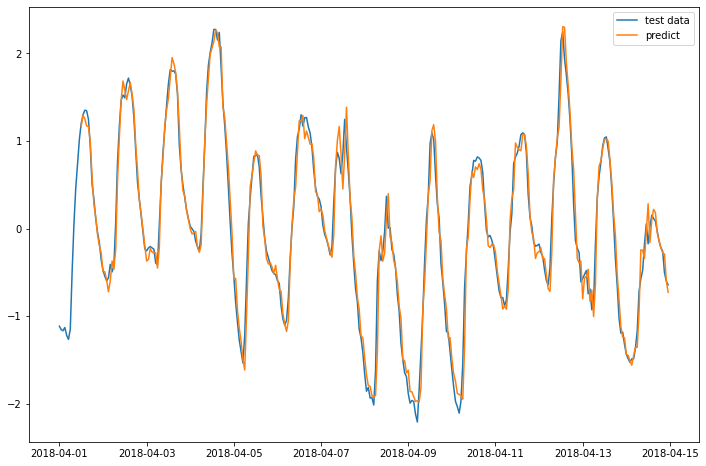

In [117]:
plt.figure(figsize=(12,8))
plt.plot(test_data.index, test_scaler, label='test data')
plt.plot(test_data.index[size:], pred, label='predict')
plt.legend()

In [142]:
#学習したモデルを使って15日〜18日の気温を予測する
#4月14日の23時を元に予測を始める
basis=x_test.tail(1).values[0]
pred_list=[]
for i in range(len(test_label)):
  pre=model.predict(basis.reshape(1,-1))
  pred_list.append(pre[0])
  dummys=list(basis[size:])
  dummys.insert(0, dummys.pop(-1))
  #次の時間帯と今予測したものを、次のデータとする
  data=list(basis[:size])
  data.pop(0)
  data.append(pre[0])
  data[len(data):len(data)]=dummys
  basis=np.array(data)
  print(basis)

[-0.17448759  0.0196341   0.15212985  0.11515429  0.08434132 -0.02658535
 -0.14059333 -0.21762574 -0.2576826  -0.50418632 -0.59970652 -0.72791016
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
[ 0.0196341   0.15212985  0.11515429  0.08434132 -0.02658535 -0.14059333
 -0.21762574 -0.2576826  -0.50418632 -0.59970652 -0.72791016 -0.79914326
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
[ 0.15212985  0.11515429  0.08434132 -0.02658535 -0.14059333 -0.21762574
 -0.2576826  -0.50418632 -0.59970652 -0.72791016 -0.79914326 -0.92622799
  0.          0.          1.          0.        

In [143]:
print('label score(R2): ', r2_score(pred_list, label_scaler))
print('label score(MSE): ', mean_squared_error(pred_list, label_scaler))

label score(R2):  -1.5121141089101844
label score(MSE):  0.6186684075670236


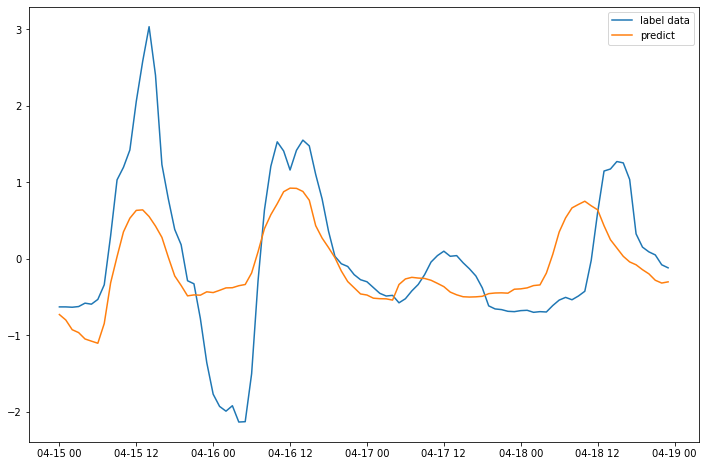

In [144]:
plt.figure(figsize=(12,8))
plt.plot(test_label.index, label_scaler, label='label data')
plt.plot(test_label.index, pred_list, label='predict')
plt.legend()